In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

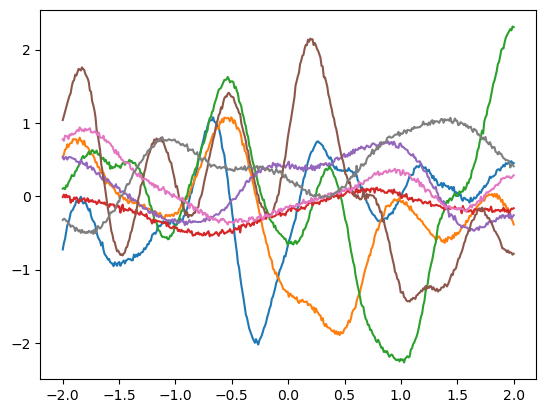

In [2]:
from data.gpdata_new import GPData
import matplotlib.pyplot as plt

sine_data_test = GPData(max_num_context=10)

batch = sine_data_test.generate_batch(batch_size=8, testing=True, device='cpu')

for i in range(8):
    x = batch.target_x[i].flatten()
    y = batch.target_y[i].flatten()
    plt.plot(x.numpy(), y.numpy())
plt.show()

In [3]:
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

def generate_knowledge(a, b, c):
    """
    a, b, c: torch.Tensor
        Shape (batch_size, 1, x_size)
    Knowledge can be none, a, b, c, ab, ac, bc 
    each vector is one-hot encoding of the parameter type with value appended to end
    e.g. if knowledge is a=1, b=0.5 then k = [1, 0, 0, 1], [0, 1, 0, 0.5]
    Returns 
    -------
    knowledge: torch.Tensor
        Shape (batch_size, num_knowledge_points, 4)
    """
    # sample types of knowledge to use as 3-vector. i.e. if ab then [1, 1, 0] if none then [0, 0, 0] etc
    binary_vector = torch.randint(0, 2, (3,))
    total_knowledge = []
    if binary_vector.sum() == 0:
        return None
    if binary_vector[0] == 1:
        # make [1, 0, 0, a]
        knowledge = torch.cat([torch.ones_like(a), torch.zeros_like(a), torch.zeros_like(a), a], dim=-1)
        total_knowledge.append(knowledge)
    if binary_vector[1] == 1:
        # make [0, 1, 0, b]
        knowledge = torch.cat([torch.zeros_like(b), torch.ones_like(b), torch.zeros_like(b), b], dim=-1)
        total_knowledge.append(knowledge)
    if binary_vector[2] == 1:
        # make [0, 0, 1, c]
        knowledge = torch.cat([torch.zeros_like(c), torch.zeros_like(c), torch.ones_like(c), c], dim=-1)
        total_knowledge.append(knowledge)
    total_knowledge = torch.cat(total_knowledge, dim=1)
    return total_knowledge



def loss_function(pred_dist: Normal, 
                  target_y: torch.Tensor,
                  posterior: Normal,
                  prior: Normal):

    batch_size, num_targets, _ = target_y.shape
    log_p = pred_dist.log_prob(target_y).sum(-1) # Shape (batch_size, num_targets)
    # assert log_p.shape[-1] == 1
    # log_p = log_p.squeeze(-1)

    kl_div = torch.sum(kl_divergence(posterior, prior), dim=-1, keepdim=True)

    loss = -torch.mean(log_p - kl_div / num_targets)
    return loss, log_p

def evaluate(model, data_generator, num_z_samples=32, num_test_batches=16, override_num_context=None, use_knowledge=False, batch_size=64):
    batch_losses = []
    device = model.device
    with torch.no_grad():
        model.training = False

        for _ in range(num_test_batches):
            batch_loss = 0
            batch = data_generator.generate_batch(batch_size=64, testing=True, override_num_context=override_num_context, device=device)
            if use_knowledge:
                knowledge = generate_knowledge(batch.a, batch.b, batch.c)
            else:
                knowledge = None
            for _ in range(num_z_samples):
                p_y_pred = model(batch.context_x, batch.context_y, knowledge, batch.target_x, batch.target_y)
                mu = p_y_pred.mean
                sigma = p_y_pred.stddev

                log_p = p_y_pred.log_prob(batch.target_y)
                log_p = log_p.mean(dim=0).mean() # Take mean over batch and mean over targets
                batch_loss += log_p
            batch_losses.append(batch_loss / num_z_samples)
    return torch.stack(batch_losses).mean().item()

Weights initialized
AttentiveNeuralProcess(
  (determinisitic_values): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): Identity()
  )
  (deterministic_qks): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Identity()
  )
  (cross_attention): CrossAttention(
    (q_proj): Linear(in_features=64, out_features=64, bias=True)
  

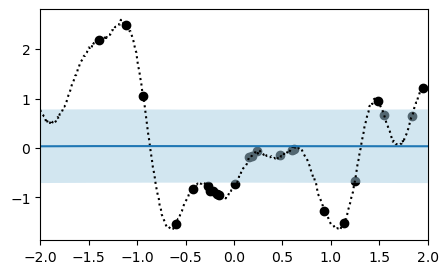

Iter: 200, Loss 0.921771,
Iter: 400, Loss 0.745063,
Iter: 600, Loss 0.767427,
Iter: 800, Loss 0.530328,
Iter: 1000, Loss 0.658821,


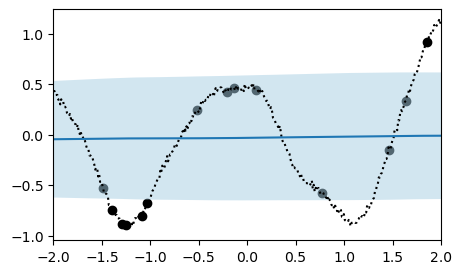

Iter: 1200, Loss 0.992068,
Iter: 1400, Loss 0.730596,
Iter: 1600, Loss 0.510855,
Iter: 1800, Loss 0.638036,
Iter: 2000, Loss 0.841235,


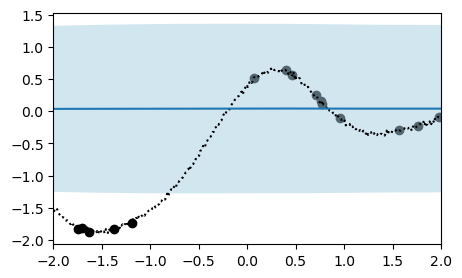

Iter: 2200, Loss 0.475882,
Iter: 2400, Loss 0.609602,
Iter: 2600, Loss 0.602942,
Iter: 2800, Loss 0.663475,
Iter: 3000, Loss 0.583361,


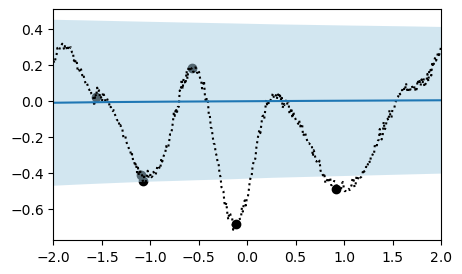

Iter: 3200, Loss 0.814096,
Iter: 3400, Loss 0.451458,
Iter: 3600, Loss 0.593396,
Iter: 3800, Loss 0.781467,
Iter: 4000, Loss 0.573488,


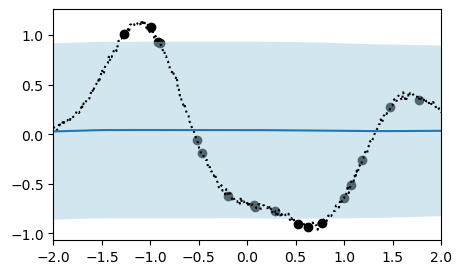

Iter: 4200, Loss 0.597860,
Iter: 4400, Loss 0.518535,
Iter: 4600, Loss 0.640167,
Iter: 4800, Loss 0.553032,
Iter: 5000, Loss 0.303349,


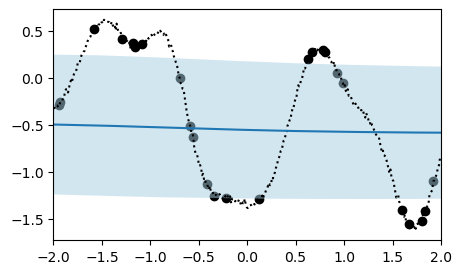

Iter: 5200, Loss 0.798901,
Iter: 5400, Loss 0.557616,
Iter: 5600, Loss 0.182848,
Iter: 5800, Loss 0.553707,
Iter: 6000, Loss 0.362156,


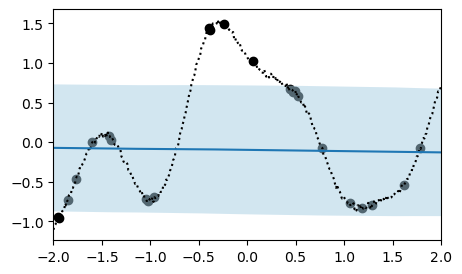

Iter: 6200, Loss 0.421164,
Iter: 6400, Loss 0.716724,
Iter: 6600, Loss 0.462885,
Iter: 6800, Loss 0.264083,
Iter: 7000, Loss 0.489094,


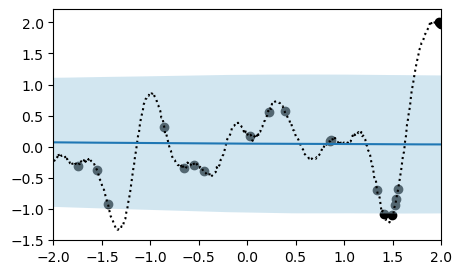

Iter: 7200, Loss 0.440748,
Iter: 7400, Loss 0.378650,
Iter: 7600, Loss 0.424448,
Iter: 7800, Loss 0.575051,
Iter: 8000, Loss 0.588160,


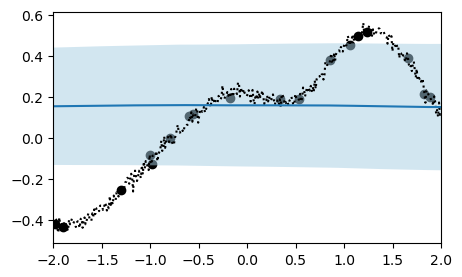

Iter: 8200, Loss 0.470381,
Iter: 8400, Loss 0.195212,
Iter: 8600, Loss 0.678421,
Iter: 8800, Loss 0.390968,
Iter: 9000, Loss 0.381464,


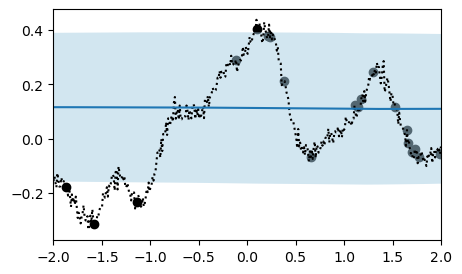

Iter: 9200, Loss 0.613007,
Iter: 9400, Loss 0.395562,
Iter: 9600, Loss 0.560196,
Iter: 9800, Loss 0.724224,
Iter: 10000, Loss 0.542181,


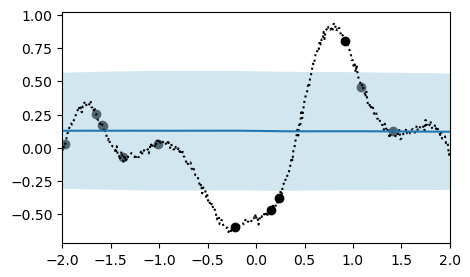

Iter: 10200, Loss 0.272904,
Iter: 10400, Loss 0.875082,
Iter: 10600, Loss 0.712297,
Iter: 10800, Loss 0.754752,
Iter: 11000, Loss 0.436335,


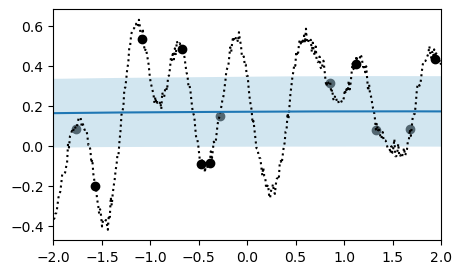

Iter: 11200, Loss 0.689325,
Iter: 11400, Loss 0.649914,
Iter: 11600, Loss 0.443645,
Iter: 11800, Loss 0.367794,
Iter: 12000, Loss 0.758345,


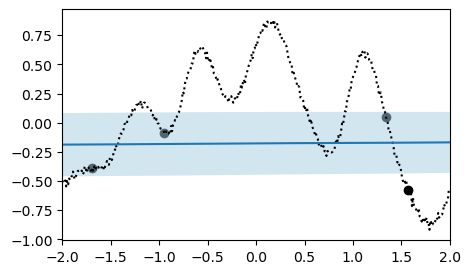

Iter: 12200, Loss 0.350294,
Iter: 12400, Loss 0.481609,
Iter: 12600, Loss 0.311371,
Iter: 12800, Loss 0.572744,
Iter: 13000, Loss 0.549949,


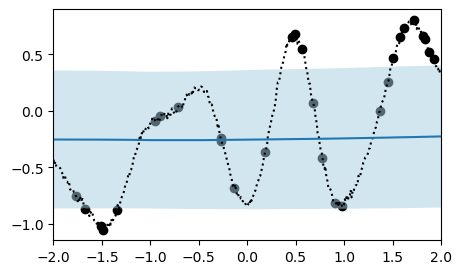

Iter: 13200, Loss 0.440249,
Iter: 13400, Loss 0.464555,
Iter: 13600, Loss 0.770110,
Iter: 13800, Loss 0.618107,
Iter: 14000, Loss 0.753955,


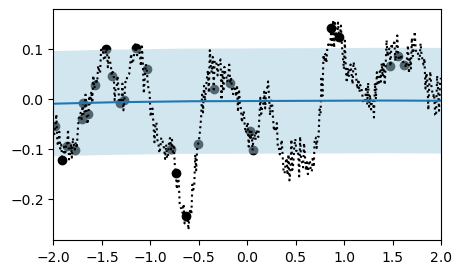

Iter: 14200, Loss 0.796961,
Iter: 14400, Loss 0.170408,
Iter: 14600, Loss 0.046534,
Iter: 14800, Loss 0.459443,
Iter: 15000, Loss 0.314765,


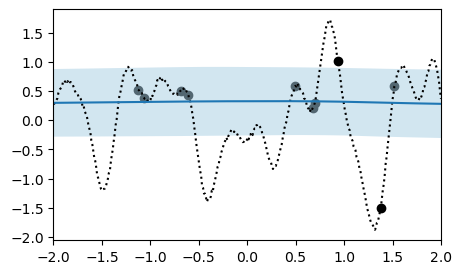

Iter: 15200, Loss 0.697695,
Iter: 15400, Loss 0.368023,
Iter: 15600, Loss 0.483541,
Iter: 15800, Loss 0.245216,
Iter: 16000, Loss 0.283263,


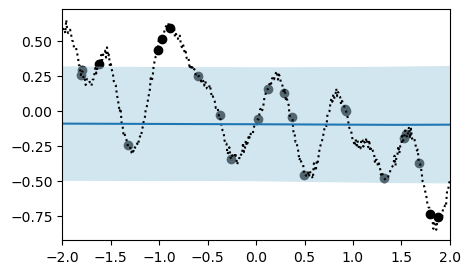

Iter: 16200, Loss 0.430724,
Iter: 16400, Loss 0.782605,
Iter: 16600, Loss 0.289271,
Iter: 16800, Loss 0.688260,
Iter: 17000, Loss 0.614387,


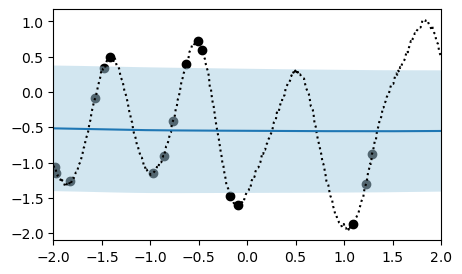

Iter: 17200, Loss 0.474019,
Iter: 17400, Loss 0.647074,
Iter: 17600, Loss 0.771275,
Iter: 17800, Loss 0.439666,
Iter: 18000, Loss 0.850644,


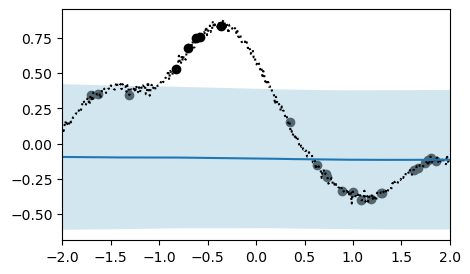

Iter: 18200, Loss 0.369376,
Iter: 18400, Loss 1.002305,
Iter: 18600, Loss 0.343983,
Iter: 18800, Loss 0.726544,
Iter: 19000, Loss 0.838672,


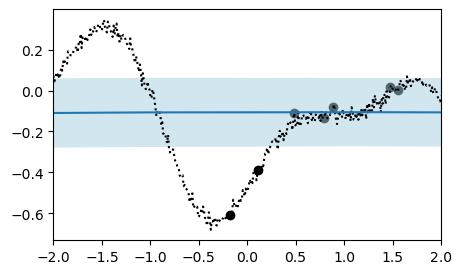

Iter: 19200, Loss 0.505796,
Iter: 19400, Loss 0.427128,
Iter: 19600, Loss 0.729312,
Iter: 19800, Loss 0.451558,
Iter: 20000, Loss 0.507658,


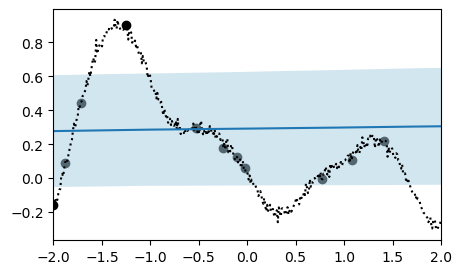

Iter: 20200, Loss 0.772400,
Iter: 20400, Loss 0.512516,
Iter: 20600, Loss 0.159200,
Iter: 20800, Loss 0.659076,


KeyboardInterrupt: 

In [7]:
from src.plot import plot_predictive
from data.sine_data import SineData
from src.attnp import AttentiveNeuralProcess
x_dim = 1
y_dim = 1
r_dim = 128  # Dimension of representation of context points
z_dim = 128  # Dimension of sampled latent variable
h_dim = 128  # Dimension of hidden layers in encoder and decoder
att_np = AttentiveNeuralProcess(x_dim=x_dim,
                                y_dim=y_dim,
                                r_dim=r_dim,
                                z_dim=z_dim,
                                embed_dim=h_dim,
                                h_dim=h_dim,
                                )
print(att_np)
print(sum(p.numel() for p in att_np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
data = GPData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(att_np.parameters(), lr=1e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
att_np.to(device)

train_loss = []
for iter in range(100000+1):
    att_np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, q_z_target, q_z_context = att_np(batch.context_x, batch.context_y, None, batch.target_x, batch.target_y)

    loss, log_p = loss_function(p_y_pred, batch.target_y, q_z_target, q_z_context)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 200 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f},") # NLL {nll:.6f}")
    if iter % 1000 == 0:
        att_np.training = False
        batch = data.generate_batch(1, testing=True, device=att_np.device)
        plot_predictive(att_np, batch, knowledge=None, save=False, iter=None)
        att_np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()


tensor([[[-0.0400],
         [-0.0400],
         [-0.0400],
         [-0.0400],
         [-0.0400],
         [-0.0400],
         [-0.0400],
         [-0.0400],
         [-0.0399],
         [-0.0399],
         [-0.0399],
         [-0.0399],
         [-0.0399],
         [-0.0399],
         [-0.0398],
         [-0.0398],
         [-0.0398],
         [-0.0398],
         [-0.0398],
         [-0.0398],
         [-0.0398],
         [-0.0397],
         [-0.0397],
         [-0.0397],
         [-0.0397],
         [-0.0397],
         [-0.0397],
         [-0.0397],
         [-0.0396],
         [-0.0396],
         [-0.0396],
         [-0.0396],
         [-0.0396],
         [-0.0396],
         [-0.0396],
         [-0.0395],
         [-0.0395],
         [-0.0395],
         [-0.0395],
         [-0.0395],
         [-0.0395],
         [-0.0394],
         [-0.0394],
         [-0.0394],
         [-0.0394],
         [-0.0394],
         [-0.0394],
         [-0.0393],
         [-0.0393],
         [-0.0393],


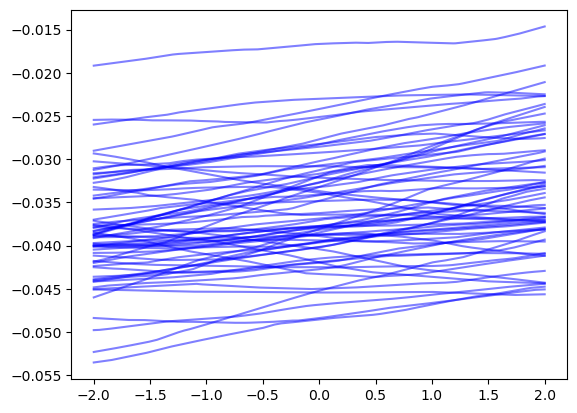

In [65]:
x_dim = 1
y_dim = 1
r_dim = 64  # Dimension of representation of context points
z_dim = 64  # Dimension of sampled latent variable
h_dim = 64  # Dimension of hidden layers in encoder and decoder
att_np = AttentiveNeuralProcess(x_dim=x_dim,
                                y_dim=y_dim,
                                r_dim=r_dim,
                                z_dim=z_dim,
                                embed_dim=h_dim,
                                h_dim=h_dim,
                                ).to(device)
batch = data.generate_batch(1, testing=True, device=device)
for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    #py = anp.decoder(batch.x_target, z_sample)
    p_y = att_np.decoder(batch.target_x, z_sample.to(device))
    mu = p_y.mean
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(batch.target_x.cpu().numpy()[0], mu.cpu().detach().numpy()[0], 
             c='b', alpha=0.5)

InformedNeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (deterministic_encoder): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): ReLU()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): ReLU()
      (12): Linear(in_features=128, out_features=128, bias=True)
      (13): Identity()
    )
  )
  (knowledge_encoder): KnowledgeEncoder(
    (phi): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (

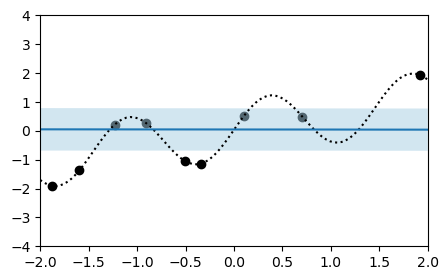

Iter: 1000, Loss 1.004816,
Iter: 2000, Loss 0.819161,


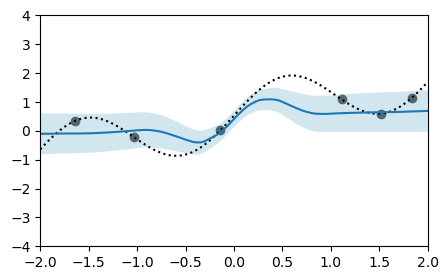

Iter: 3000, Loss 0.699027,
Iter: 4000, Loss 0.718966,


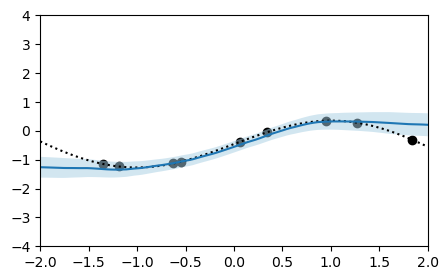

Iter: 5000, Loss 0.527668,
Iter: 6000, Loss 0.336174,


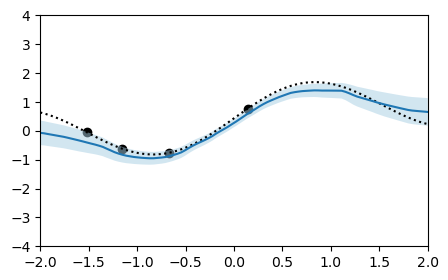

Iter: 7000, Loss 0.337541,
Iter: 8000, Loss 0.369124,


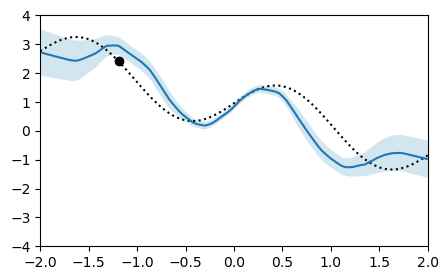

Iter: 9000, Loss 0.075685,
Iter: 10000, Loss -0.190456,


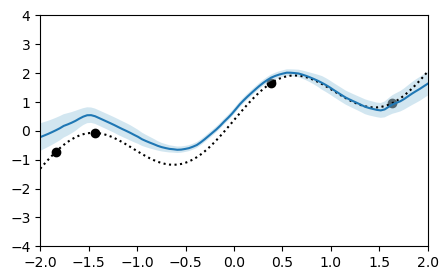

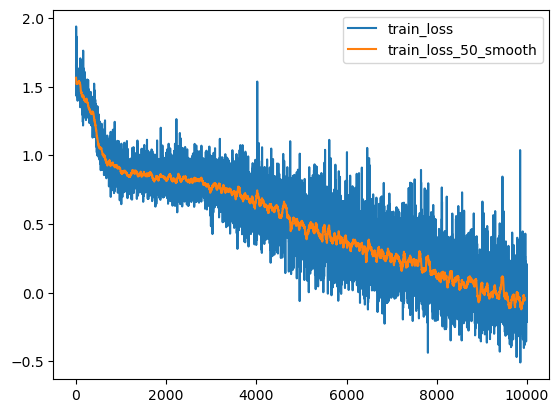

In [74]:
inf_model = InformedNeuralProcess(
    x_size=1,
    y_size=1,
    r_size=128,
    z_size=128,
    xK_size=4,
    k_size=128,
    h_size_dec=128,
    h_size_enc_det=128,
    h_size_enc_know=128,
    h_size_agg=128,
    N_h_layers_dec=3,
    N_h_layers_enc_know_phi=2,
    N_h_layers_enc_know_rho=2,
    N_h_layers_enc_det=6,
    N_h_layers_agg=3
)
print(inf_model)
print(sum(p.numel() for p in inf_model.parameters() if p.requires_grad))

optimiser = torch.optim.Adam(inf_model.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
inf_model.to(device)

train_loss = []
for iter in range(10000+1):
    inf_model.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    knowledge = generate_knowledge(batch.a, batch.b, batch.c)
    p_y_pred, q_z_target, q_z_context = inf_model(batch.context_x, batch.context_y, knowledge, batch.target_x, batch.target_y)

    loss, log_p = loss_function(p_y_pred, batch.target_y, q_z_target, q_z_context)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 1000 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f},") # NLL {nll:.6f}")
    if iter % 2000 == 0:
        inf_model.training = False
        batch = data.generate_batch(1, testing=True, device=inf_model.device)
        knowledge = generate_knowledge(batch.a, batch.b, batch.c)
        plot_predictive(inf_model, batch, knowledge=knowledge, save=False, iter=None)
        inf_model.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()


[NP] Num_context points: 1, Test Loss: -19.613810
[NP] Num_context points: 2, Test Loss: -13.765142
[NP] Num_context points: 3, Test Loss: -11.074625
[NP] Num_context points: 4, Test Loss: -6.709089
[NP] Num_context points: 5, Test Loss: -7.084566
[NP] Num_context points: 6, Test Loss: -4.687437
[NP] Num_context points: 7, Test Loss: -4.614048
[NP] Num_context points: 8, Test Loss: -4.630173
[NP] Num_context points: 9, Test Loss: -2.635783
[NP] Num_context points: 10, Test Loss: -2.776935
[NP] Num_context points: 11, Test Loss: -2.297745
[NP] Num_context points: 12, Test Loss: -2.352884
[NP] Num_context points: 13, Test Loss: -1.625952
[NP] Num_context points: 14, Test Loss: -1.885280
[NP] Num_context points: 15, Test Loss: -0.670694
[NP] Num_context points: 16, Test Loss: -0.658828
[NP] Num_context points: 17, Test Loss: -0.734276
[NP] Num_context points: 18, Test Loss: -0.849096
[NP] Num_context points: 19, Test Loss: -0.658041
[NP] Num_context points: 20, Test Loss: -1.041951
[INP]:

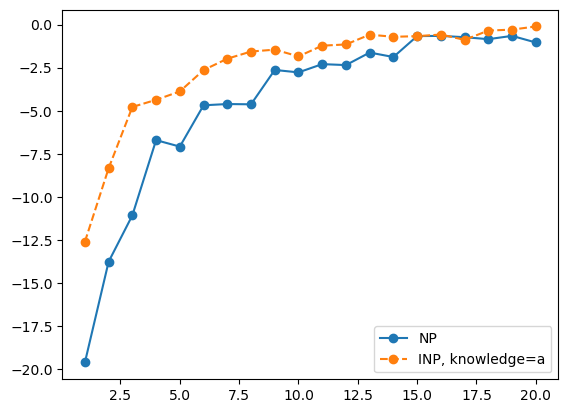

In [81]:
np_scores = []
for override_num_context in range(1, 21):
    np_test_score = evaluate(np_model, data, override_num_context=override_num_context, use_knowledge=False, batch_size=64)
    print(f"[NP] Num_context points: {override_num_context}, Test Loss: {np_test_score:.6f}")
    np_scores.append(np_test_score)

inf_scores = []
for override_num_context in range(1, 21):
    inf_test_score = evaluate(inf_model, data, override_num_context=override_num_context, use_knowledge=True, batch_size=64)
    print(f"[INP]: Num_context points: {override_num_context}, Test Loss: {inf_test_score:.6f}")
    inf_scores.append(inf_test_score)

plt.plot(range(1, 21), np_scores, "o-", label='NP')
plt.plot(range(1, 21), inf_scores, "o--", label='INP, knowledge=a')
plt.legend()
plt.show()